In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.models import  Model
from sklearn.utils import resample
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from google.colab import drive
import time

In [ ]:
# Plot metrics acc, val_acc and loss, val_loss
def plot_metrics(history, suptitle):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(history.history['loss']))

    # Plot accuracy
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='accuracy')
    plt.plot(epochs_range, val_acc, label='validation_accurancy')
    plt.legend(loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('accuracy and validation_accurancy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='loss')
    plt.plot(epochs_range, val_loss, label='validation_loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('loss and validation_loss')

    plt.suptitle(suptitle, fontsize=20)
    plt.show()
    return

# Dataset

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/deadskull7/fer2013/download?datasetVersionNumber=1")

In [ ]:
df_data = pd.read_csv('/content/fer2013/fer2013.csv')
df_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
label_to_text = {0:'angry', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sad', 5: 'surprise', 6: 'neutral'}

In [ ]:
# convert pixel values in string format to array format
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [ ]:
df_data['pixels'] = df_data['pixels'].apply(lambda x: string2array(x))

<Axes: ylabel='count'>

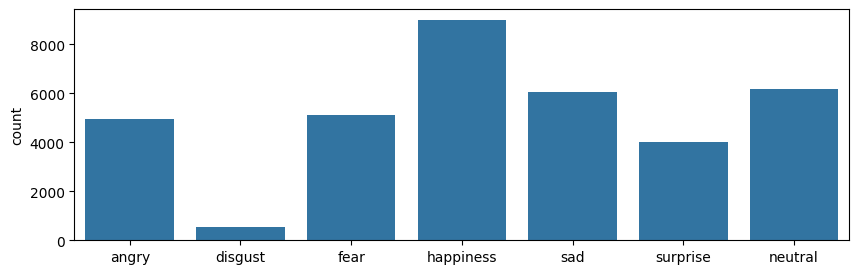

In [ ]:
plt.figure(figsize = (10,3))
sns.barplot(x = label_to_text, y = df_data.emotion.value_counts())

In [ ]:
# Calculate the average class count
average_class_count = df_data['emotion'].value_counts().mean()
average_class_count

5126.714285714285

In [ ]:
# Separate data for each class
class_data = [df_data[df_data['emotion'] == i] for i in range(7)]

In [ ]:
# Oversample to balance classes based on average class count
oversampled_data = [resample(class_df, replace=True, n_samples=int(average_class_count), random_state=42) for class_df in class_data]
balanced_data = pd.concat(oversampled_data)

<Axes: ylabel='count'>

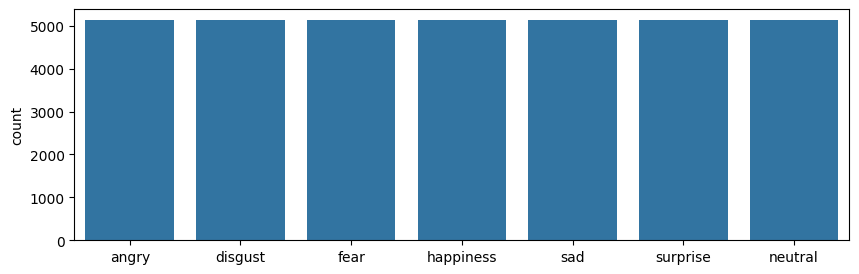

In [ ]:
plt.figure(figsize = (10,3))
sns.barplot(x = label_to_text, y = balanced_data.emotion.value_counts())

In [ ]:
# hold-out validation
x_train, x_temp, y_train, y_temp = train_test_split(balanced_data['pixels'], balanced_data['emotion'], test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

In [ ]:
print("Train set size:", x_train.shape[0])
print("Validation set size:", x_val.shape[0])
print("Test set size:", x_test.shape[0])

Train set size: 28705
Validation set size: 3588
Test set size: 3589


In [ ]:
# one-hot
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
# reshape
x_train = np.stack(x_train, axis = 0)
x_train = x_train.reshape(28705 , 48, 48, 1)

x_test = np.stack(x_test, axis = 0)
x_test = x_test.reshape(3589 , 48, 48, 1)

x_val = np.stack(x_val, axis = 0)
x_val = x_val.reshape(3588 , 48, 48, 1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(28705, 48, 48, 1) (28705, 7)
(3589, 48, 48, 1) (3589, 7)
(3588, 48, 48, 1) (3588, 7)


# Modeling

In [ ]:
def create_model(learning_rate, regularization_rate=0, dropout_rate = 0, input_shape=(48,48,1)):

  base_model = tf.keras.applications.MobileNetV2(input_shape=(96,96,3),
                                                 include_top=False,
                                                 weights='imagenet')

  # Inputlayer
  input = tf.keras.layers.Input(name='0_Input',
                                shape=input_shape)

  # Preprocessing stage
  x = tf.keras.layers.Resizing(name='1_Preprocessing_1',height = 96, width = 96)(input)
  x = tf.keras.layers.Rescaling(name='1_Preprocessing_2',
                                scale = 1/127.0, offset=-1)(x)
  x = tf.keras.layers.RandomRotation(name='1_Preprocessing_3',
                                     factor=0.20,
                                     seed=100)(x)
  x = tf.keras.layers.RandomFlip(name='1_Preprocessing_4',
                                 mode="horizontal",
                                 seed=100)(x)
  x = tf.keras.layers.Conv2D(name='1_Preprocessing_5',
                             filters=3,
                             kernel_size=(1, 1),
                             padding='same',
                             activation='tanh')(x)

  # Feature extracting stage
  x = base_model(x)
  x = tf.keras.layers.Flatten(name='3_Classification_1')(x)

  # Classification stage
  x = tf.keras.layers.Dense(name='3_Classification_2',
                            units=256,
                            kernel_regularizer=tf.keras.regularizers.l2(l2=regularization_rate),
                            kernel_initializer = 'he_uniform',
                            activation='relu')(x)
  x = tf.keras.layers.BatchNormalization(name='3_Classification_3')(x)
  x = tf.keras.layers.Dropout(name='3_Classification_4',
                              rate=dropout_rate)(x)
  # Prediction stage
  predictions = tf.keras.layers.Dense(name='4_Prediction',
                                      units = 7,
                                      kernel_initializer = 'zeros',
                                      activation=tf.nn.softmax)(x)

  keras_model = Model(inputs=input, outputs=predictions)

  keras_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

  return keras_model, base_model

In [ ]:
# Parameter
batch_size = 32
epochs = 100
learning_rate = 0.0001
dropout_rate = 0.4
regularization_rate = 0.1
es_patience = 15
lrp_patience = 10
lrp_factor = 0.1

In [ ]:
reg_model, base_model = create_model(learning_rate = learning_rate,
                                     dropout_rate = dropout_rate,
                                     regularization_rate = regularization_rate)

# freeze layers
for layer in reg_model.layers[:7]:
    layer.trainable = False

base_model.trainable = False

reg_model.summary(show_trainable=True)

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 0_Input (InputLayer)        [(None, 48, 48, 1)]       0         N          
                                                                            
 1_Preprocessing_1 (Resizin  (None, 96, 96, 1)         0         N          
 g)                                                                         
                                                                            
 1_Preprocessing_2 (Rescali  (None, 96, 96, 1)         0         N          
 ng)                                                                        
                                                                            
 1_Preprocessing_3 (RandomR  (None, 96, 96, 1)         0         N          
 otation)                                                                  

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 8.6 MB/s eta 0:00:00


In [ ]:
from collections import defaultdict

color_map = defaultdict(dict)
color_map[tf.keras.layers.Conv2D]['fill'] = 'orange'
color_map[tf.keras.layers.Input]['fill'] = 'gray'
color_map[tf.keras.layers.Dropout]['fill'] = 'pink'
color_map[tf.keras.layers.Resizing]['fill'] = 'red'
color_map[tf.keras.layers.Dense]['fill'] = 'green'
color_map[tf.keras.layers.Flatten]['fill'] = 'teal'
color_map[tf.keras.layers.BatchNormalization]['fill'] = 'black'

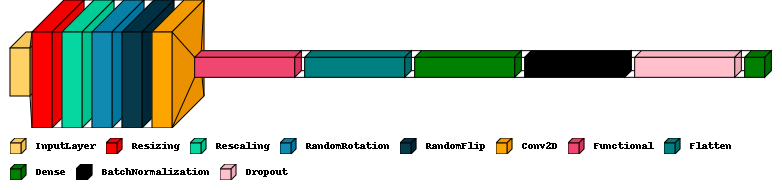

In [ ]:
import visualkeras
visualkeras.layered_view(reg_model, legend=True, scale_xy=1, scale_z=1, max_z=100, color_map=color_map)
# visualkeras.layered_view(reg_model, legend=True, scale_xy=1, scale_z=1, max_z=100)

# Training

In [ ]:
early_stopping = EarlyStopping(patience=es_patience, restore_best_weights=True)

lrp_reducer = ReduceLROnPlateau(monitor='val_loss', factor=lrp_factor, patience=lrp_patience, verbose=1)

In [ ]:
# training
t_start = time.time()

reg_hist = reg_model.fit(x_train,
                         y_train,
                         batch_size=batch_size,
                         epochs = epochs,
                         validation_data = (x_val,y_val),
                         callbacks = [lrp_reducer, early_stopping])

t_end = time.time()
reg_t_duration = t_end - t_start

Epoch 1/100
898/898 [==============================] - 86s 47ms/step - loss: 5.5194 - accuracy: 0.4119 - val_loss: 1.7643 - val_accuracy: 0.3804 - lr: 1.0000e-04
Epoch 2/100
898/898 [==============================] - 40s 44ms/step - loss: 1.3684 - accuracy: 0.5425 - val_loss: 1.6583 - val_accuracy: 0.4047 - lr: 1.0000e-04
Epoch 3/100
898/898 [==============================] - 41s 45ms/step - loss: 1.2359 - accuracy: 0.5896 - val_loss: 1.4549 - val_accuracy: 0.5014 - lr: 1.0000e-04
Epoch 4/100
898/898 [==============================] - 39s 44ms/step - loss: 1.1488 - accuracy: 0.6231 - val_loss: 1.3099 - val_accuracy: 0.5555 - lr: 1.0000e-04
Epoch 5/100
898/898 [==============================] - 39s 44ms/step - loss: 1.0797 - accuracy: 0.6450 - val_loss: 1.1228 - val_accuracy: 0.6296 - lr: 1.0000e-04
Epoch 6/100
898/898 [==============================] - 37s 41ms/step - loss: 1.0225 - accuracy: 0.6645 - val_loss: 1.0013 - val_accuracy: 0.6686 - lr: 1.0000e-04
Epoch 7/100
898/898 [=======

# Validation

In [ ]:
# validation
reg_score, reg_acc = reg_model.evaluate(x=x_test, y=y_test)
print('Test Loss =', reg_score)
print('Test Accuracy =', reg_acc*100)

113/113 [==============================] - 2s 16ms/step - loss: 0.7069 - accuracy: 0.8144
Test Loss = 0.7068618535995483
Test Accuracy = 81.44329786300659


In [ ]:
test_data = df_data[df_data['Usage'] == 'PublicTest']
x_test2 = test_data['pixels']
y_test2 = to_categorical(test_data['emotion'])
x_test2 = np.stack(x_test2, axis = 0)
x_test2 = x_test2.reshape(3589 , 48, 48, 1)
print(x_test2.shape, y_test2.shape)

reg_score_2, reg_acc_2 = reg_model.evaluate(x=x_test2, y=y_test2)
print('Test Loss =', reg_score_2)
print('Test Accuracy =', reg_acc_2*100)

(3589, 48, 48, 1) (3589, 7)
113/113 [==============================] - 1s 11ms/step - loss: 0.8269 - accuracy: 0.7866
Test Loss = 0.8268747329711914
Test Accuracy = 78.65700721740723


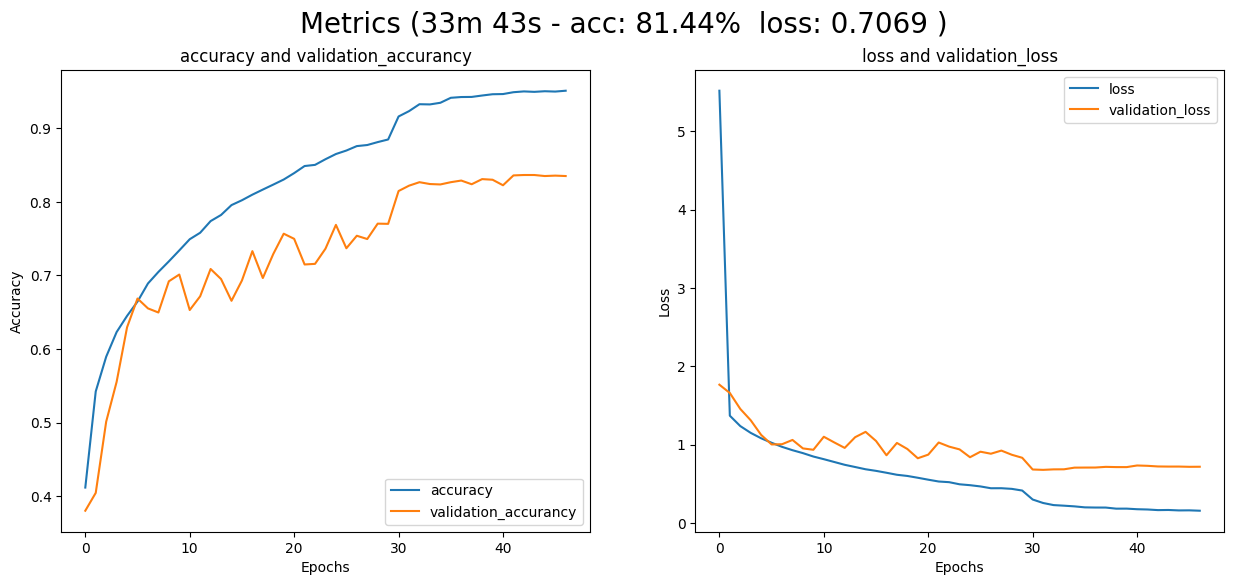

Accuracy: 81.44%
Loss:  0.7068618535995483
Epochs:  46
Train time : 33m 43s 

Batch Size: 32
initial learning rate: 0.0001
dropout rate: 0.4
Early Stopping patience: 15
ReduceLROnPlateau patience: 10
ReduceLROnPlateau factor: 0.1
L2 regularization rate: 0.1


In [ ]:
train_time = '{:.0f}m {:.0f}s - acc: {:.2f}%  loss: {:.4f} '.format((reg_t_duration/60), (reg_t_duration%60), (reg_acc*100), reg_score)

plot_metrics(reg_hist, ('Metrics ('+ train_time+')'))

print('================================================')
print("Accuracy: %.2f%%" % (reg_acc * 100))
print("Loss:  %s" % reg_score)
print("Epochs:  %d" % max(range(len(reg_hist.history['loss']))))
print("Train time : %0.0fm %0.0fs \n" % (reg_t_duration/60, reg_t_duration%60))
print("Batch Size: %s" % batch_size)
print('================================================')
print("initial learning rate: %s" % learning_rate)
print("dropout rate: %s" % dropout_rate)
print("Early Stopping patience: %s" % es_patience)
print("ReduceLROnPlateau patience: %s" % lrp_patience)
print("ReduceLROnPlateau factor: %s" %lrp_factor)
print("L2 regularization rate: %s" % regularization_rate)

In [ ]:
predictions = reg_model.predict(x_test)

113/113 [==============================] - 1s 11ms/step


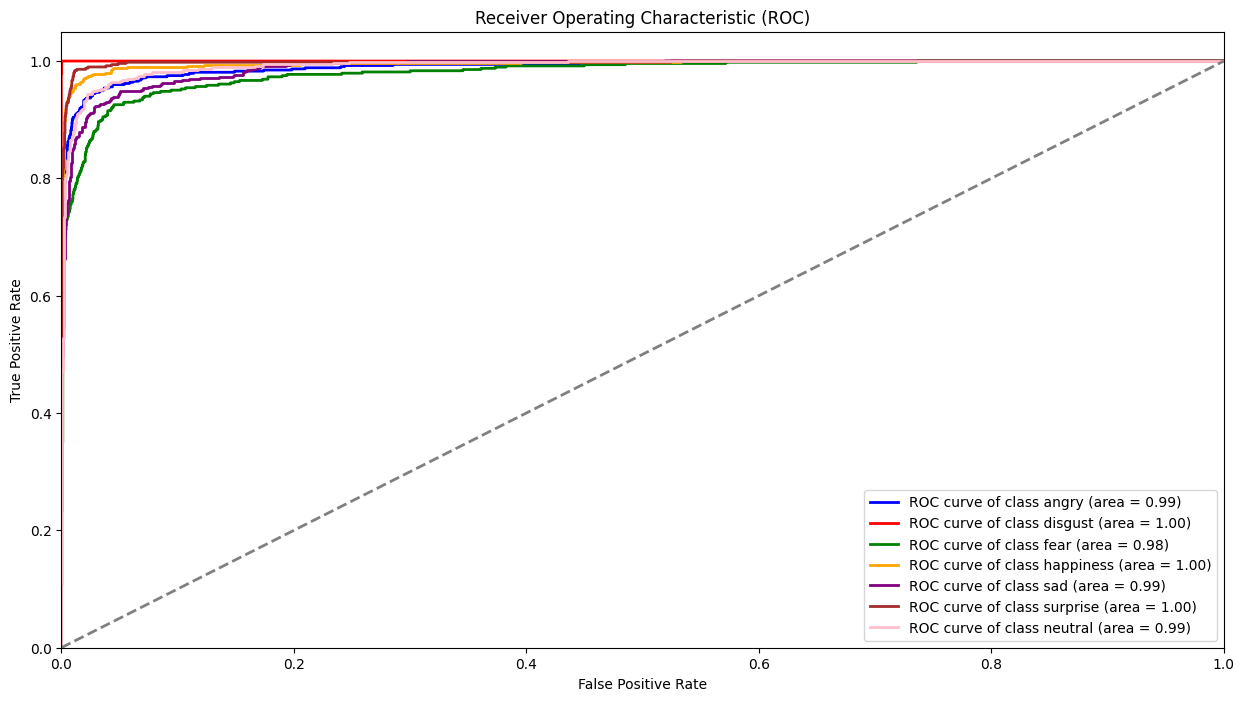

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
for i, color in zip(range(7), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(label_to_text[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

fig = plt.gcf()
fig.set_size_inches(15, 8)

plt.show()

In [ ]:
predictions = np.argmax(predictions, axis=1)

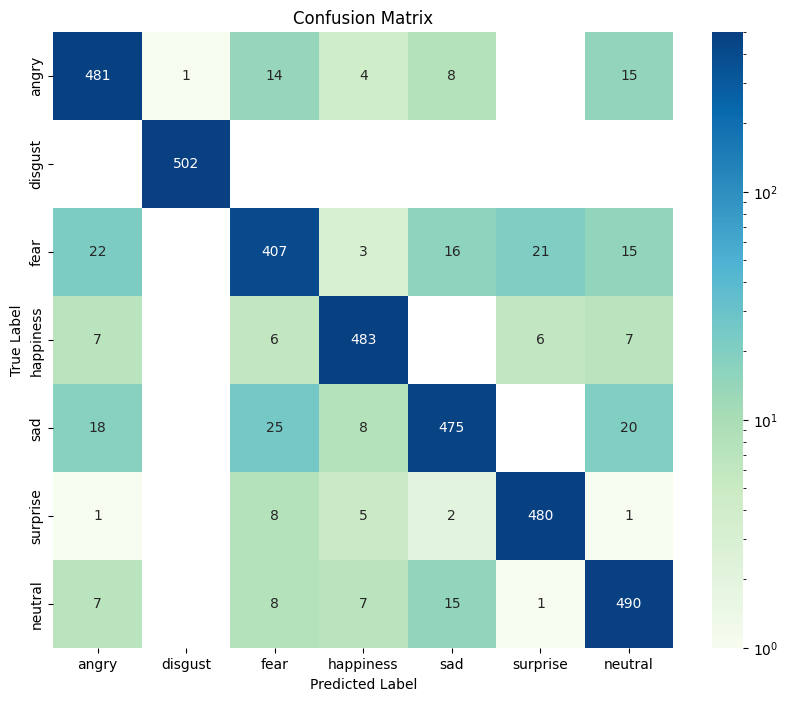

In [ ]:
from sklearn.metrics import confusion_matrix

true_labels = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(true_labels, predictions)
from matplotlib.colors import LogNorm

conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='GnBu', fmt='g', xticklabels=[label_to_text[i] for i in range(len(conf_matrix))], yticklabels=[label_to_text[i] for i in range(len(conf_matrix))], norm=LogNorm())

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

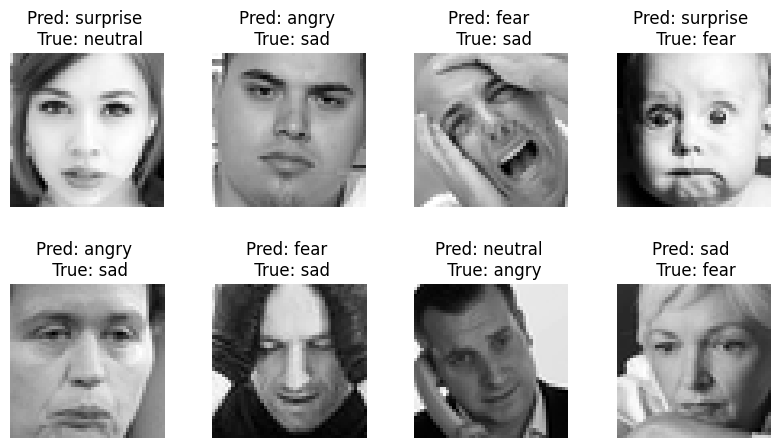

In [ ]:
# false predictions
incorrect_indices = np.where(predictions != true_labels)[0]
images = x_test

num_rows = 2
num_cols = 4

plt.figure(figsize=(10, 5))
plt.subplots_adjust(hspace=0.5)

for i, idx in enumerate(incorrect_indices[:num_rows * num_cols]):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(images[idx], cmap='gray')
    plt.title(f'Pred: {label_to_text[predictions[idx]]} \n True: {label_to_text[true_labels[idx]]}')
    plt.axis('off')

plt.show()

In [ ]:
# f1-score
from sklearn.metrics import f1_score
f1 = f1_score(true_labels, predictions, average='weighted')

print("F1-Score:", f1)

F1-Score: 0.9242180979631427
